In [1]:
import numpy as np
from cmdstanpy import cmdstan_path, CmdStanModel, set_cmdstan_path

import matplotlib.pyplot as plt
import arviz as az
import os
import tqdm

import sys
sys.path.append('../scripts')
    
from parameter_estimation import BivariateBeta

## Stan Model

For using the following notebook, it is necessary to set the `cmdstan` path correctly. 

In [2]:
set_cmdstan_path('/home/lucasmoschen/anaconda3/envs/project-beta/bin/cmdstan')

Then, we can proceed the compilation.

In [94]:
stanfile1 = os.path.join('..', 'scripts', 'bivariate-beta-model.stan')
model_v1 = CmdStanModel(stan_file=stanfile1, cpp_options={'STAN_THREADS':'true'})

stanfile2 = os.path.join('..', 'scripts', 'bivariate-beta-model-v2.stan')
model_v2 = CmdStanModel(stan_file=stanfile2, cpp_options={'STAN_THREADS':'true'})

stanfile3 = os.path.join('..', 'scripts', 'bivariate-beta-model-v3.stan')
model_v3 = CmdStanModel(stan_file=stanfile3, cpp_options={'STAN_THREADS':'true'})

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:found newer exe file, not recompiling


## Quick verifications

Generating the data

In [95]:
true_alpha = np.array([2,7,3,1])
n = 50
U = np.random.dirichlet(true_alpha, size=n)
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]
XY = np.column_stack([X,Y])

# Gamma hyperparameters
a = 0.001*np.array([1,1,1,1])
b = 0.001*np.array([1,1,1,1])

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.5*np.ones(4)
lambd = np.ones(4)
c = 100*np.ones(4)

data = {'n': n, 'xy': XY, 
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

## Model V1

In [35]:
model_fit_v1 = model_v1.sample(data=data, chains=4, iter_sampling=1000)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [36]:
print(model_fit_v1.diagnose())

Processing csv files: /tmp/tmp_r6pcmes/bivariate-beta-model-20220615111800_1.csv, /tmp/tmp_r6pcmes/bivariate-beta-model-20220615111800_2.csv, /tmp/tmp_r6pcmes/bivariate-beta-model-20220615111800_3.csv, /tmp/tmp_r6pcmes/bivariate-beta-model-20220615111800_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [37]:
df = model_fit_v1.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],1.00,0.0037,0.19,0.70,0.99,1.3,2747.0,6.2,1.0
alpha[2],0.80,0.0033,0.17,0.54,0.79,1.1,2757.0,6.2,1.0
alpha[3],0.97,0.0039,0.20,0.67,0.96,1.3,2649.0,5.9,1.0
alpha[4],1.00,0.0038,0.20,0.72,1.00,1.4,2809.0,6.3,1.0


In [38]:
inf_data = az.from_cmdstanpy(model_fit_v1)

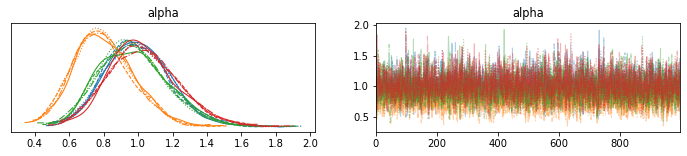

In [39]:
az.plot_trace(inf_data)
plt.show()

## Model V2

In [114]:
model_fit_v2 = model_v2.sample(data=data, chains=4, iter_sampling=1000, iter_warmup=1000, adapt_delta=0.9)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [117]:
print(model_fit_v3.diagnose())

Processing csv files: /tmp/tmpawtmov0d/bivariate-beta-model-v3-20220616113737_1.csv, /tmp/tmpawtmov0d/bivariate-beta-model-v3-20220616113737_2.csv, /tmp/tmpawtmov0d/bivariate-beta-model-v3-20220616113737_3.csv, /tmp/tmpawtmov0d/bivariate-beta-model-v3-20220616113737_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
1 of 4000 (0.03%) transitions ended with a divergence.
These divergent transitions indicate that HMC is not fully able to explore the posterior distribution.
Try increasing adapt delta closer to 1.
If this doesn't remove all divergences, try to reparameterize the model.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.26, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters

In [107]:
df = model_fit_v2.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],2.00,0.028,0.51,1.30,2.00,3.0,340.0,139.0,1.0
alpha[2],7.20,0.039,1.20,5.40,7.10,9.2,892.0,364.0,1.0
alpha[3],2.80,0.011,0.45,2.00,2.70,3.5,1712.0,698.0,1.0
alpha[4],0.88,0.021,0.36,0.39,0.83,1.5,283.0,115.0,1.0


## Model V3 

Let it to be faster! I couldn't yet, unhappily...

In [187]:
model_fit_v3 = model_v3.sample(data=data, chains=4, iter_sampling=1000, iter_warmup=1500, adapt_delta=0.9)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [188]:
print(model_fit_v3.diagnose())

Processing csv files: /tmp/tmpawtmov0d/bivariate-beta-model-v3-20220616120134_1.csv, /tmp/tmpawtmov0d/bivariate-beta-model-v3-20220616120134_2.csv, /tmp/tmpawtmov0d/bivariate-beta-model-v3-20220616120134_3.csv, /tmp/tmpawtmov0d/bivariate-beta-model-v3-20220616120134_4.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.



In [189]:
df = model_fit_v3.summary()
df[df.index.str.contains('alpha')]

,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
name,,,,,,,,,
alpha[1],2.10,0.034,0.51,1.40,2.1,3.0,225.0,81.0,1.0
alpha[2],7.10,0.032,1.10,5.40,7.1,9.1,1247.0,450.0,1.0
alpha[3],2.70,0.012,0.47,2.00,2.7,3.5,1480.0,534.0,1.0
alpha[4],0.94,0.027,0.37,0.42,0.9,1.6,183.0,66.0,1.0


## Comparing v1 and v2

They should provide similar estimates for the same data.

In [43]:
comparing = ['Mean', '5%', '50%', '95%']
diff = abs(model_fit_
           v1.summary()[comparing].iloc[1:5] - model_fit_v2.summary()[comparing].iloc[1:5])
diff = diff/model_fit_v1.summary()[comparing].iloc[1:5]
# the percentage error is
diff

,Mean,5%,50%,95%
name,,,,
alpha[1],0.010000,0.000000,0.010101,0.0
alpha[2],0.012500,0.018519,0.012658,0.0
alpha[3],0.010309,0.014925,0.020833,0.0
alpha[4],0.000000,0.013889,0.000000,0.0


## Prior analysis model v2

In [177]:
data['prior_alpha'] = 1
model_fit1 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 2
model_fit2 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 3
model_fit3 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 4
model_fit4 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)
data['prior_alpha'] = 5
model_fit5 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False)

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing


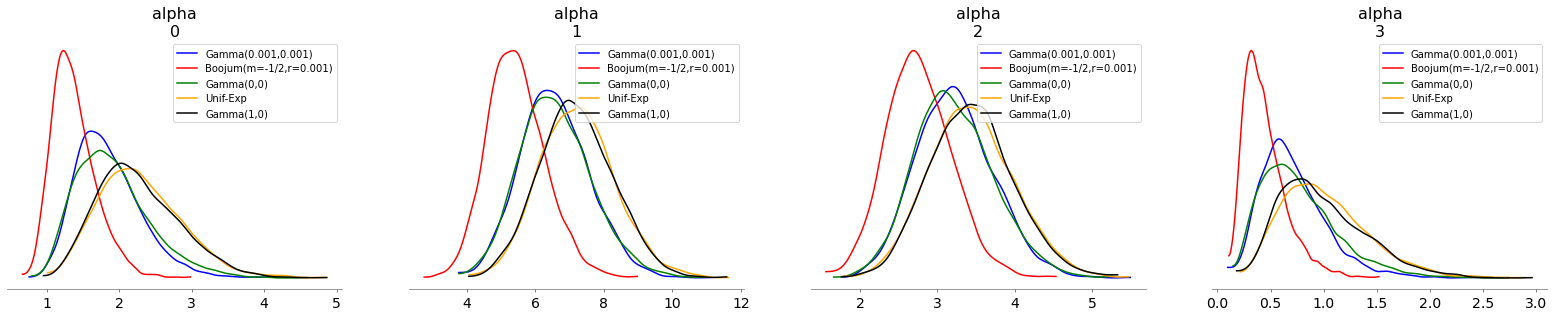

In [178]:
ax = az.plot_posterior(model_fit1, var_names=['alpha'], hdi_prob='hide', point_estimate=None, color='blue', label='Gamma(0.001,0.001)')
az.plot_posterior(model_fit2, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='red', label='Boojum(m=-1/2,r=0.001)')
az.plot_posterior(model_fit3, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='green', label='Gamma(0,0)')
az.plot_posterior(model_fit4, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='orange', label='Unif-Exp')
az.plot_posterior(model_fit5, var_names=['alpha'], ax=ax, hdi_prob='hide', point_estimate=None, color='black', label='Gamma(1,0)')
plt.show()

## Marginal gain of increasing sampling

In [225]:
true_alpha = np.array([2,7,3,1])

# Gamma hyperparameters
a = 0.001*np.array([1,1,1,1])
b = 0.001*np.array([1,1,1,1])

n = 50
U = np.random.dirichlet(true_alpha, size=n)
X = U[:,0] + U[:,1]
Y = U[:,0] + U[:,2]
XY = np.column_stack([X,Y])

data = {'n': n, 'xy': XY, 
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

In [247]:
n_values = [10, 30, 50, 100, 200, 500, 1000]
alpha_samples = np.zeros((len(n_values),4000,4))

for i, n in enumerate(n_values):
    
    U = np.random.dirichlet(true_alpha, size=n)
    X = U[:,0] + U[:,1]
    Y = U[:,0] + U[:,2]
    XY = np.column_stack([X,Y])
    
    data['n'] = n
    data['xy'] = XY
    model_fit = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False, show_console=False)
    
    alpha_samples[i,:,:] = model_fit.stan_variable('alpha')

INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing


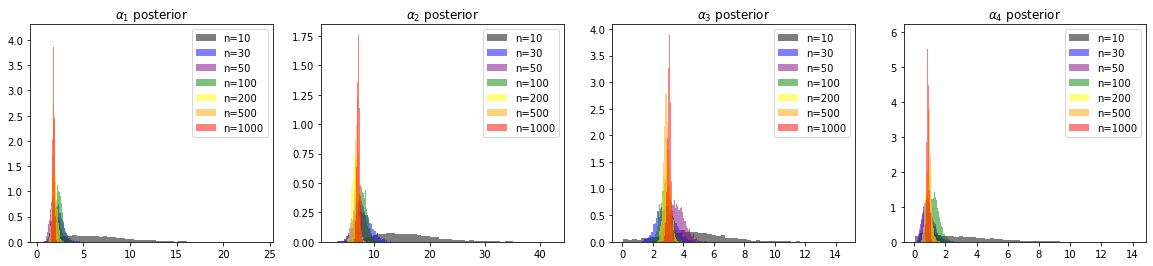

In [250]:
fig, ax = plt.subplots(1, 4, figsize=(20,4))
colors = ['black', 'blue', 'purple', 'green', 'yellow', 'orange', 'red']
for i in range(4):
    for k in range(7):
        ax[i].hist(alpha_samples[k,:,i], bins=50, color=colors[k], alpha=0.5, label='n={}'.format(n_values[k]), density=True)
    ax[i].set_title(r'$\alpha_{}$ posterior'.format(i+1))
    ax[i].legend()
plt.show()

## Analyzing the estimation

In [185]:
true_alpha = np.array([1,1,1,1])
n = 50
monte_carlo_simulation = 1000
U = np.random.dirichlet(true_alpha, size=(n, monte_carlo_simulation))
X = U[:,:,0] + U[:,:,1]
Y = U[:,:,0] + U[:,:,2]

In [186]:
# Gamma hyperparameters
a = 0.001*np.array([1,1,1,1])
b = 0.001*np.array([1,1,1,1])

# bojum prior
m = -0.9
r = b

# uniform-exponential prior
p = 0.5*np.ones(4)
lambd = np.ones(4)
c = 100*np.ones(4)

data = {'n': n, 'xy': XY, 
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

In [187]:
mse = np.zeros(4)
bias = np.zeros(4)
coverage = np.zeros(4)
mape = np.zeros(4)

for i in tqdm.tqdm(range(monte_carlo_simulation)):
    XY = np.column_stack([X[:,i],Y[:,i]])
    data['xy'] = XY
    model_fit_v2 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False, show_console=False)
    df = model_fit_v2.summary(percentiles=(2.5, 97.5))
    
    alpha_hat = df.iloc[1:5].Mean.values
    lb = df.iloc[1:5]['2.5%'].values
    ub = df.iloc[1:5]['97.5%'].values
    
    bias_new = alpha_hat - true_alpha
    mse_new = bias_new * bias_new
    mape_new = abs(bias_new)/true_alpha
    coverage_new = (lb < true_alpha)*(ub > true_alpha)
    
    bias = (bias * i + bias_new)/(i+1)
    mse = (mse * i + mse_new)/(i+1)
    mape = (mape * i + mape_new)/(i+1)
    coverage = (coverage * i + coverage_new)/(i+1)

  0%|                                                  | 0/1000 [00:00<?, ?it/s]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  0%|                                        | 1/1000 [00:04<1:14:14,  4.46s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  0%|                                        | 2/1000 [00:09<1:17:58,  4.69s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  0%|                                        | 3/1000 [00:14<1:17:57,  4.69s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  0%|▏                                       | 4/1000 [00:18<1:16:57,  4.64s/it]INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan start processing
INFO:cmdstanpy:CmdStan done processing
  0%|

In [188]:
true_alpha = np.array([1,1,1,1])
n = 1000
monte_carlo_simulation = 1000
U = np.random.dirichlet(true_alpha, size=(n, monte_carlo_simulation))
X = U[:,:,0] + U[:,:,1]
Y = U[:,:,0] + U[:,:,2]

In [189]:
data = {'n': n, 'xy': XY, 
        'prior_alpha': 1, 'a': a, 'b': b, 'm': m, 'r': r, 'p': p, 'lambda': lambd, 'c': c, 
        'tolerance': 1e-8}

In [194]:
coverage

array([0.936, 0.931, 0.94 , 0.935])

In [ ]:
mse2 = np.zeros(4)
bias2 = np.zeros(4)
coverage2 = np.zeros(4)
mape2 = np.zeros(4)

for i in tqdm.tqdm(range(monte_carlo_simulation)):
    XY = np.column_stack([X[:,i],Y[:,i]])
    data['xy'] = XY
    model_fit_v2 = model_v2.sample(data=data, chains=4, iter_sampling=1000, show_progress=False, show_console=False)
    df = model_fit_v2.summary(percentiles=(2.5, 97.5))
    
    alpha_hat = df.iloc[1:5].Mean.values
    lb = df.iloc[1:5]['2.5%'].values
    ub = df.iloc[1:5]['97.5%'].values
    
    bias_new = alpha_hat - true_alpha
    mse_new = bias_new * bias_new
    mape_new = abs(bias_new)/true_alpha
    coverage_new = (lb < true_alpha)*(ub > true_alpha)
    
    bias2 = (bias2 * i + bias_new)/(i+1)
    mse2 = (mse2 * i + mse_new)/(i+1)
    mape2 = (mape2 * i + mape_new)/(i+1)
    coverage2 = (coverage2 * i + coverage_new)/(i+1)

## Jeffreys' prior

Calculating Jeffreys prior for $p(\alpha, u)$.

In [64]:
import sympy as sp

In [86]:
alpha1, alpha2, alpha3, alpha4, u, x, y = sp.symbols('alpha_1 alpha_2 alpha_3 alpha4 u x y')

f = (x-u)**(alpha2-1) * (y-u)**(alpha3-1) * (1-x-y+u)**(alpha4-1) / (1-u)**(alpha2+alpha3+alpha4-1)
f /= sp.gamma(alpha2)*sp.gamma(alpha3)*sp.gamma(alpha4)/sp.gamma(alpha2+alpha3+alpha4)
l = sp.expand_log(sp.log(f), force=True)

In [87]:
l_2 = sp.diff(l, alpha2)
l_3 = sp.diff(l, alpha3)
l_4 = sp.diff(l, alpha4)
l_u = sp.diff(l, u)

M = sp.Matrix([[l_2.diff(alpha2), l_2.diff(alpha3), l_2.diff(alpha4), l_2.diff(u)],
               [l_3.diff(alpha2), l_3.diff(alpha3), l_3.diff(alpha4), l_3.diff(u)],
               [l_4.diff(alpha2), l_4.diff(alpha3), l_4.diff(alpha4), l_4.diff(u)],
               [l_u.diff(alpha2), l_u.diff(alpha3), l_u.diff(alpha4), l_u.diff(u)]])

M

Matrix([
[-polygamma(1, alpha_2) + polygamma(1, alpha4 + alpha_2 + alpha_3),                          polygamma(1, alpha4 + alpha_2 + alpha_3),                         polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                                 -1/(-u + x) + 1/(1 - u)],
[                         polygamma(1, alpha4 + alpha_2 + alpha_3), -polygamma(1, alpha_3) + polygamma(1, alpha4 + alpha_2 + alpha_3),                         polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                                 -1/(-u + y) + 1/(1 - u)],
[                         polygamma(1, alpha4 + alpha_2 + alpha_3),                          polygamma(1, alpha4 + alpha_2 + alpha_3), -polygamma(1, alpha4) + polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                           1/(u -

$x-u = u_2 \sim Beta(\alpha_2, \alpha_1+\alpha_3+\alpha_4)$

$y-u = u_3 \sim Beta(\alpha_3, \alpha_1+\alpha_2+\alpha_4)$

$1-x-y+u = u_4 \sim Beta(\alpha_4, \alpha_1+\alpha_2+\alpha_3)$

I notice that if $X \sim Beta(\alpha, \beta)$, then $E[X^{-n}] = B(\alpha-n, \beta)/Beta(\alpha, \beta)$ if $\alpha > n$ and infinity otherwise.

In [99]:
M[3,3] = M[3,3].subs(1/(x-u)**2, sp.beta(alpha2-2, alpha1+alpha3+alpha4)/sp.beta(alpha2, alpha1+alpha3+alpha4))
M[3,3] = M[3,3].subs(1/(y-u)**2, sp.beta(alpha3-2, alpha1+alpha2+alpha4)/sp.beta(alpha3, alpha1+alpha2+alpha4))
v = M[3,3].subs(1/(1-x-y+u)**2, sp.beta(alpha4-2, alpha1+alpha2+alpha3)/sp.beta(alpha4, alpha1+alpha2+alpha3))
M = M.subs(1/(x-u), sp.beta(alpha2-1, alpha1+alpha3+alpha4)/sp.beta(alpha2, alpha1+alpha3+alpha4))
M = M.subs(1/(y-u), sp.beta(alpha3-1, alpha1+alpha2+alpha4)/sp.beta(alpha3, alpha1+alpha2+alpha4))
M = M.subs(1/(1-x-y+u), sp.beta(alpha4-1, alpha1+alpha2+alpha3)/sp.beta(alpha4, alpha1+alpha2+alpha3))
M[3,3] = v
M

Matrix([
[                                   -polygamma(1, alpha_2) + polygamma(1, alpha4 + alpha_2 + alpha_3),                                                             polygamma(1, alpha4 + alpha_2 + alpha_3),                                                            polygamma(1, alpha4 + alpha_2 + alpha_3),                                                                                                                                                                                                                                                                 -beta(alpha_2 - 1, alpha4 + alpha_1 + alpha_3)/beta(alpha_2, alpha4 + alpha_1 + alpha_3) + 1/(1 - u)],
[                                                            polygamma(1, alpha4 + alpha_2 + alpha_3),                                    -polygamma(1, alpha_3) + polygamma(1, alpha4 + alpha_2 + alpha_3),                                                            polygamma(1, alpha4 + alpha_2 + alpha_3),                     

Note que a priori de Jeffreys só está definida se $\alpha_i > 2, i=2,3,4$, isto é, a densidade tem valor inifinito se $\alpha_2 \le 2$, por exemplo.